In [1]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2024-06-21 12:43:44--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [application/octet-stream]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.06s   

2024-06-21 12:43:45 (190 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [29]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
# from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
# from subword_nmt.learn_bpe import learn_bpe
# from subword_nmt.apply_bpe import BPE

import numpy as np
from numpy import save


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!git clone https://github.com/intsystems/Ignashin-BS-Thesis

Cloning into 'Ignashin-BS-Thesis'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 491 (delta 135), reused 149 (delta 67), pack-reused 258
Receiving objects: 100% (491/491), 38.56 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (80/80), done.


In [ ]:
# path_do_data

In [ ]:
# new_path_do_data = path_do_data.split('.txt')[0] + '_new.txt'
# new_path_do_data

'./data_new.txt'

In [ ]:
# with open(path_do_data, "r", encoding="utf-8") as source_file:
#     lines = source_file.readlines()
#     new_lines = []
#     for line in lines :
#         if 20 < len(line.split('\t')[0].split(' ') ) :
#             new_lines.append(line)
# with open(new_path_do_data, "w", encoding="utf-8") as new_file:
#     new_file.writelines(new_lines)


In [ ]:
# %cp ./data.txt /content/drive/MyDrive/DIPLOM/data/data.txt
# %cp ./data_new.txt /content/drive/MyDrive/DIPLOM/data/data_new.txt

# LOAD DATA

In [ ]:
# new_path_do_data = '/content/drive/MyDrive/DIPLOM/data/data_new.txt'

In [6]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path= path_do_data ,#new_path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [11]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9336
Unique tokens in target (en) vocabulary: 6735


#MODELS

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda')

In [14]:
%cd /content/Ignashin-BS-Thesis/code/src

/content/Ignashin-BS-Thesis/code/src


In [15]:
BATCH_SIZE = 256
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key= lambda x : len(x.src)
)

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator) , history

In [19]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            output = model(src, trg, 0) #turn off teacher forcing
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            history.append(loss.cpu().data.numpy())

    return epoch_loss / len(iterator) , history

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
import utils
import tqdm
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten
from nltk.translate.bleu_score import corpus_bleu

In [22]:
def trainer(model , path = None, init_weights=init_weights , N_EPOCHS=1 , CLIP=1  ):
    model.apply(init_weights)
    print(count_parameters(model))

    PAD_IDX = TRG.vocab.stoi['<pad>']
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

    train_history = []
    valid_history = []
    train_epoch_history = []
    valid_epoch_history = []

    for epoch in range(N_EPOCHS):
        start_time = time.time()
        train_loss_epoch , train_losses = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss_epoch , val_losses = evaluate(model, valid_iterator, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        train_epoch_history.append(train_loss_epoch)
        valid_epoch_history.append(valid_loss_epoch)

        train_history += train_losses
        valid_history += val_losses
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss_epoch:.3f} | Train PPL: {math.exp(train_loss_epoch):7.3f}')
        print(f'\t Val. Loss: {valid_loss_epoch:.3f} |  Val. PPL: {math.exp(valid_loss_epoch):7.3f}')
    return train_history, valid_history , train_epoch_history , valid_epoch_history

## DATA

In [ ]:
sentence_lengths = []
alpha = 0.05
for i, batch in tqdm.tqdm(enumerate(train_iterator)):
    src = batch.src
    trg = batch.trg
    if len(sentence_lengths) == 0 :
        sentence_lengths = (src != 1).sum(axis=-1).cpu() / src.shape[1]
    else :
        sentence_lengths =  torch.cat([sentence_lengths , (src != 1).sum(axis=0).cpu() / src.shape[0]])

157it [00:05, 29.29it/s]


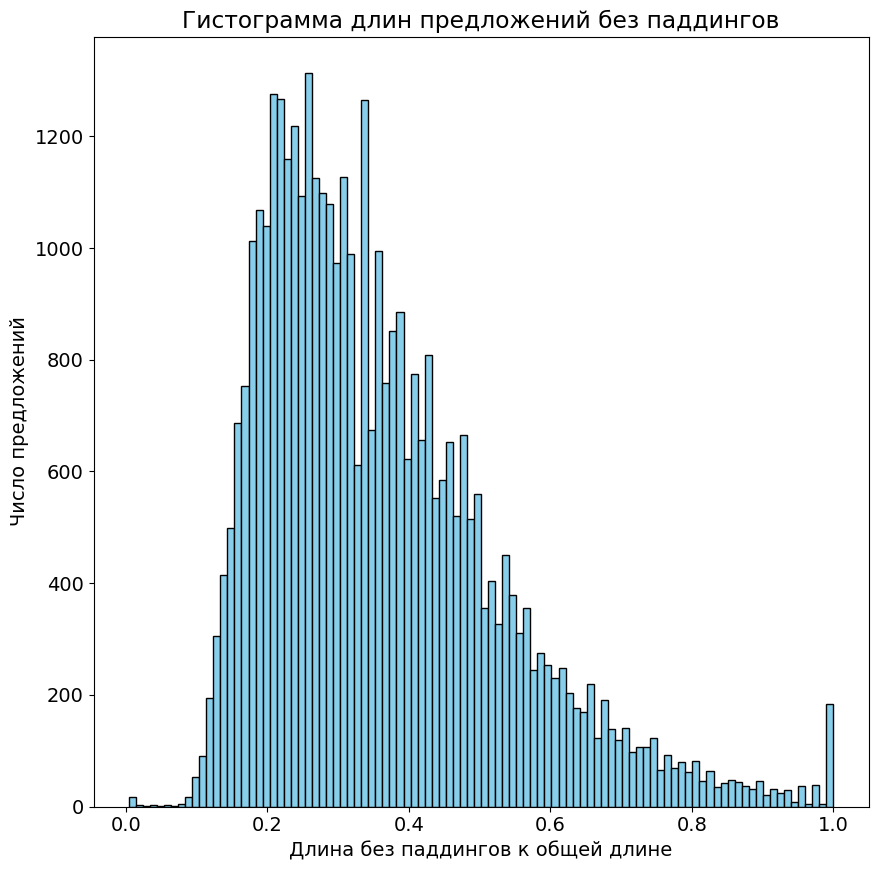

In [ ]:

plt.figure(figsize = (10,10))
plt.hist(sentence_lengths, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Длина без паддингов к общей длине')
plt.ylabel('Число предложений')
plt.title('Гистограмма длин предложений без паддингов')
plt.show()

## RNN обычный

In [ ]:
# import my_network
# Encoder = my_network.Encoder
# Decoder = my_network.Decoder
# Seq2Seq = my_network.Seq2Seq

In [ ]:
# INPUT_DIM = len(SRC.vocab)
# OUTPUT_DIM = len(TRG.vocab)
# ENC_EMB_DIM = 128
# DEC_EMB_DIM = 128
# HID_DIM = 128
# N_LAYERS = 1
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

# enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
# dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# count_parameters(model)

1241202

In [ ]:
# train_history_rnn , valid_history_rnn ,_,_= trainer(model= model ,init_weights=init_weights , N_EPOCHS=30)

In [ ]:
# import numpy as np
# from numpy import save
# PATH = '//content/drive/MyDrive/DIPLOM/Plots/'
# save(PATH+'train_history_rnn' , np.array(train_history_rnn) )
# save(PATH+'valid_history_rnn' ,valid_history_rnn)

In [ ]:
# original_text = []
# generated_text = []
# model.eval()
# with torch.no_grad():
#     for i, batch in tqdm.tqdm(enumerate(test_iterator)):
#         src = batch.src
#         trg = batch.trg
#         output = model(src, trg, 0) #turn off teacher forcing
#         output = output.argmax(dim=-1)
#         original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
#         generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

12it [00:00, 25.60it/s]


In [ ]:
# corpus_bleu([[text] for text in original_text], generated_text) * 100

# Улучшим RNN : добавим attention (1 implementation over baseline)

In [ ]:
# %cd /content
# %mkdir version_2
# %cd version_2
# !git clone https://github.com/intsystems/Ignashin-BS-Thesis
# %cd Ignashin-BS-Thesis
# %cd code
# %cd src

In [24]:
import my_network2
EncoderAtt = my_network2.Encoder
DecoderAtt = my_network2.Decoder
Seq2SeqAtt = my_network2.Seq2Seq

In [37]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelAtt = Seq2SeqAtt(enc, dec, device).to(device)

In [38]:
modelAtt

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9336, 512)
    (rnn): LSTM(512, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6735, 512)
    (rnn): LSTM(1024, 512, dropout=0.5)
    (out): Linear(in_features=512, out_features=6735, bias=True)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [39]:
# for n, p in modelAtt.named_parameters() :
#     if 'attention' in n :
#         print(n , p )

In [40]:
count_parameters(modelAtt)

17460304

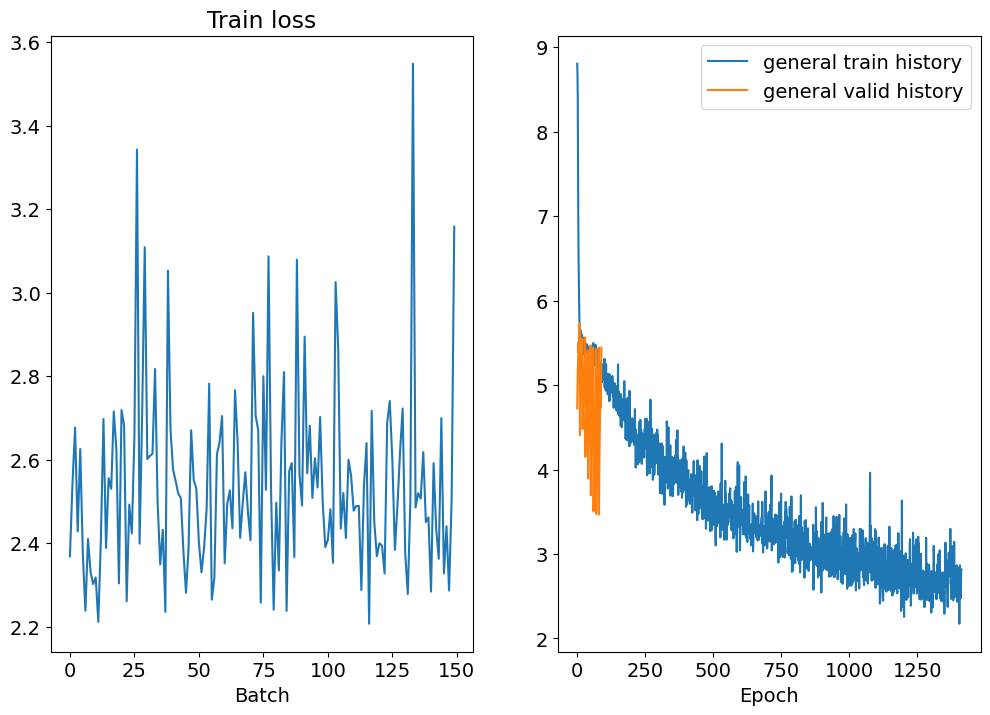

Epoch: 10 | Time: 3m 0s
	Train Loss: 2.539 | Train PPL:  12.671
	 Val. Loss: 4.489 |  Val. PPL:  89.007


In [41]:
train_history_att , valid_history_att ,_,_= trainer(model= modelAtt ,init_weights=init_weights , N_EPOCHS=10)

In [64]:

PATH = '//content/drive/MyDrive/DIPLOM/Plots/'
save(PATH+'train_history_att' , np.array(train_history_att) )
save(PATH+'valid_history_att' ,valid_history_att)

In [43]:
original_text = []
generated_text = []
modelAtt.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = modelAtt(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1)
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
corpus_bleu([[text] for text in original_text], generated_text) * 100

30it [00:08,  3.48it/s]


23.707599018125038

In [44]:
r = 106
print(generated_text[r])
print(original_text[r])

['free', 'parking', '.']
['take', 'advantage', 'of', 'hotel', "'", 's', 'free', 'private', 'parking', '.']


## save RNN attention weights

In [ ]:
# %mkdir //content/drive/MyDrive/WeightsModels

In [ ]:
# %mkdir //content/drive/MyDrive/Plots

In [ ]:
# PATH = '/content/drive/MyDrive/DIPLOM/WeightsModels/rnn_attention'
# %ls /content/drive/MyDrive/DIPLOM/WeightsModels

rnn_attention


In [ ]:
# torch.save(modelAtt.state_dict(), PATH)

In [ ]:
# modelAtt.load_state_dict(torch.load(PATH))

In [ ]:
# the_model.load_state_dict(torch.load(PATH))
# torch.save(the_model, PATH)

# SAMPLING RNN ATTENTION

In [ ]:
# sample_models = []
# for j in range(5) :
#     train_history_att , valid_history_att ,_,_= trainer(model= modelAtt ,init_weights=init_weights )
#     dict_names = {}
#     for name, param in modelAtt.named_parameters():
#         dict_names[name] = param
#     sample_models.append(dict_names)

## Teacher_sampled model

In [ ]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [ ]:
# # copy weights from old model layers module to new model layers module
# source_layers = old_model.layers
# target_layers = new_model.layers
# for source_param, target_param in zip(source_layers.parameters(), target_layers.parameters()):
#     target_param.data.copy_(source_param.data)

# # copy weights from old model desc_norm module to new model desc_norm module
# source_desc_norm = old_model.desc_norm
# target_desc_norm = new_model.desc_norm

# for source_param, target_param in zip(source_desc_norm.parameters(), target_desc_norm.parameters()):
#     target_param.data.copy_(source_param.data)

## Init RNN without attention with uniform parametrization

In [25]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, without_attention = True)

modelWithoutAtt = Seq2SeqAtt(enc, dec, device , without_attention = True).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
count_parameters(modelWithoutAtt)

16934479

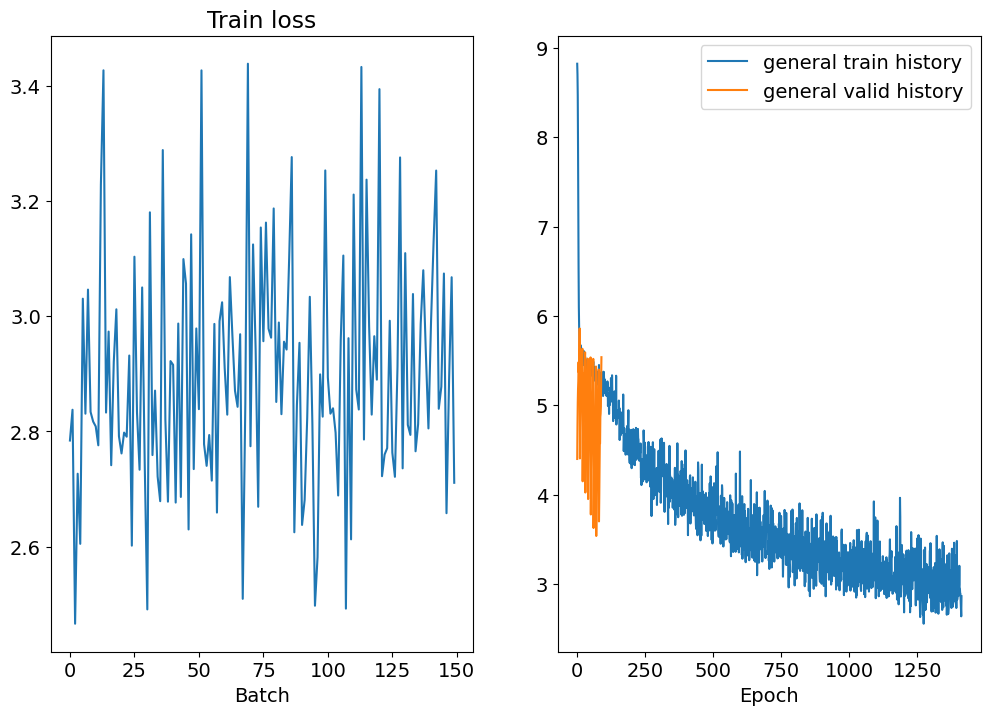

Epoch: 10 | Time: 1m 58s
	Train Loss: 2.900 | Train PPL:  18.171
	 Val. Loss: 4.617 |  Val. PPL: 101.153


In [27]:
train_history_without_1 , valid_history_without_1 ,_,_= trainer(model= modelWithoutAtt ,init_weights=init_weights , N_EPOCHS=10)

In [63]:
PATH = '//content/drive/MyDrive/DIPLOM/Plots/'
save(PATH+'train_history_without_1' , np.array(train_history_without_1) )
save(PATH+'valid_history_without_1' ,valid_history_without_1)

In [31]:
original_text = []
generated_text = []
modelWithoutAtt.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = modelWithoutAtt(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1)
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
corpus_bleu([[text] for text in original_text], generated_text) * 100

30it [00:07,  3.83it/s]


13.348835607380927

## RNN wthout attention with parameters from RNN with attention

In [45]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, without_attention = True)

modelWithoutAtt_2 = Seq2SeqAtt(enc, dec, device , without_attention = True).to(device)

In [46]:
count_parameters(modelWithoutAtt_2)

16934479

In [47]:
# for name , params in modelAtt.named_parameters() :
#     print(name)
# print('\n')
# for name , params in modelWithoutAtt_2.named_parameters() :
#     print(name)

In [48]:
def distil_weights(m, teacher_model):
    dict_names = {}
    for name, param in teacher_model.named_parameters():
        dict_names[name] = param
    for name, param in m.named_parameters():
        if name in dict_names.keys() :
            param.data.copy_(dict_names[name].data)

In [49]:
# dict_names = {}
# for name, param in modelAtt.named_parameters():
#     dict_names[name] = param
# for name, param in modelWithoutAtt_2.named_parameters():
#     if name in dict_names.keys() :
#         print(name , (dict_names[name] == param ) )

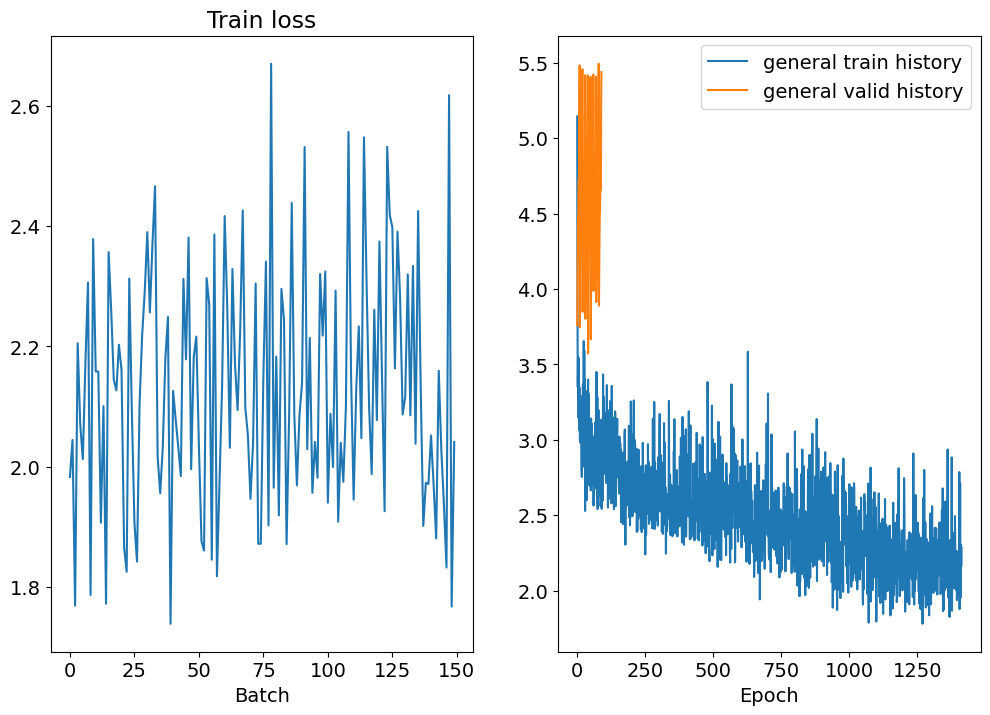

Epoch: 10 | Time: 2m 0s
	Train Loss: 2.124 | Train PPL:   8.363
	 Val. Loss: 4.745 |  Val. PPL: 114.973


In [50]:
train_history_without_2 , valid_history_without_2 ,_,_= trainer(model= modelWithoutAtt_2 ,init_weights=lambda m: distil_weights(m , modelAtt) , N_EPOCHS=10)

In [62]:
PATH = '//content/drive/MyDrive/DIPLOM/Plots/'
save(PATH+'train_history_without_2' , np.array(train_history_without_2) )
save(PATH+'valid_history_without_2' ,valid_history_without_2)

In [55]:
original_text = []
generated_text = []
modelWithoutAtt_2.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        output = modelWithoutAtt_2(src, trg, 0) #turn off teacher forcing
        output = output.argmax(dim=-1)
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
corpus_bleu([[text] for text in original_text], generated_text) * 100

30it [00:07,  4.25it/s]


17.734026797437863

## Дистилляция при параметрах ~N( teacher.parameters , I )

In [ ]:
# example= None
# for name, param in modelAtt.named_parameters():
#     print(param.data.shape)
#     example = param.data
#     break
# example.to(device)

In [ ]:
# normal_0_1 = (torch.ones(example.shape)+torch.randn(example.shape)).to(device)

In [ ]:
# wtf

In [ ]:
# wtf = example * normal_0_1

In [ ]:
# def distil_weights_normal(m, teacher_model):
#     dict_names = {}
#     for name, param in teacher_model.named_parameters():
#         dict_names[name] = param
#     for name, param in m.named_parameters():
#         if name in dict_names.keys() :
#             data_ = dict_names[name].data
#             # param.data.copy_( data_ + (torch.randn(data_.shape)).to(device))

#             # param.data.copy_( data_ + (torch.ones(data_.shape)+torch.randn(data_.shape)/100).to(device))
#             # param.data.copy_( data_)

In [ ]:
# INPUT_DIM = len(SRC.vocab)
# OUTPUT_DIM = len(TRG.vocab)
# ENC_EMB_DIM = 512
# DEC_EMB_DIM =512
# HID_DIM = 512
# N_LAYERS = 1
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

# enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
# dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, without_attention = True)

# modelWithoutAtt_3 = Seq2SeqAtt(enc, dec, device , without_attention = True).to(device)

In [ ]:
# train_history_without_3 , valid_history_without_3 ,_,_= trainer(model= modelWithoutAtt_3 ,init_weights=lambda m: distil_weights_normal(m , modelAtt) )

In [ ]:
# PATH = '//content/drive/MyDrive/DIPLOM/Plots/'
# save(PATH+'train_history_without_3' , np.array(train_history_without_3) )
# save(PATH+'valid_history_without_3' ,valid_history_without_3)

## Сравним модель с вниманием и две модели без внимания с разными инициализациями

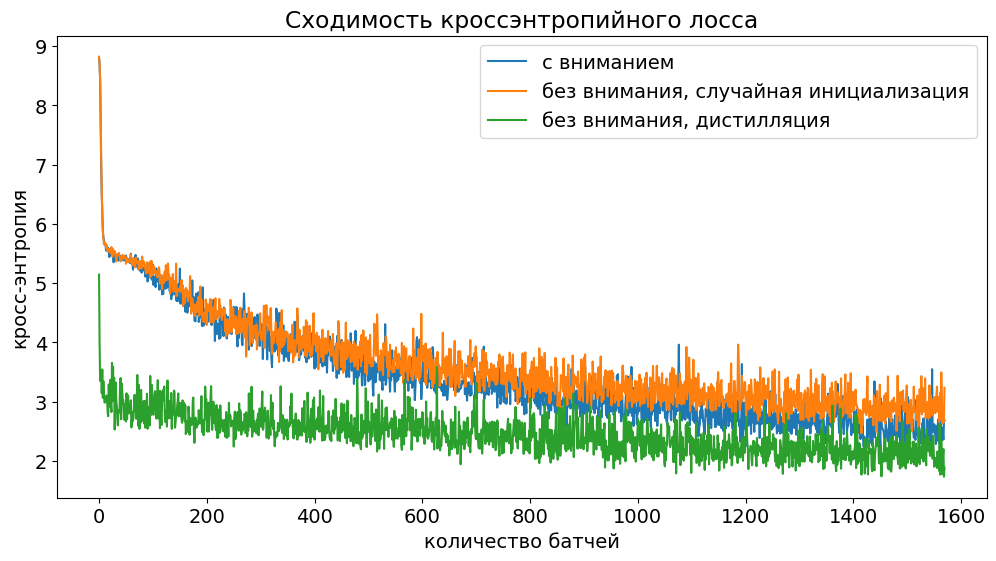

In [60]:
plt.figure(figsize=(12,6))

# plt.plot(train_history_rnn , label ='rnn (in my_network)')
plt.plot(train_history_att , label ='с вниманием')
plt.plot(train_history_without_1 , label = 'без внимания, случайная инициализация')
plt.plot(train_history_without_2 , label ='без внимания, дистилляция')
# plt.plot(train_history_without_3 , label ='without attention, distilation: Normal(teacher.params , I ) ')
plt.ylabel('кросс-энтропия')
plt.xlabel('количество батчей')
plt.title('Сходимость кроссэнтропийного лосса')
plt.legend()
plt.show()

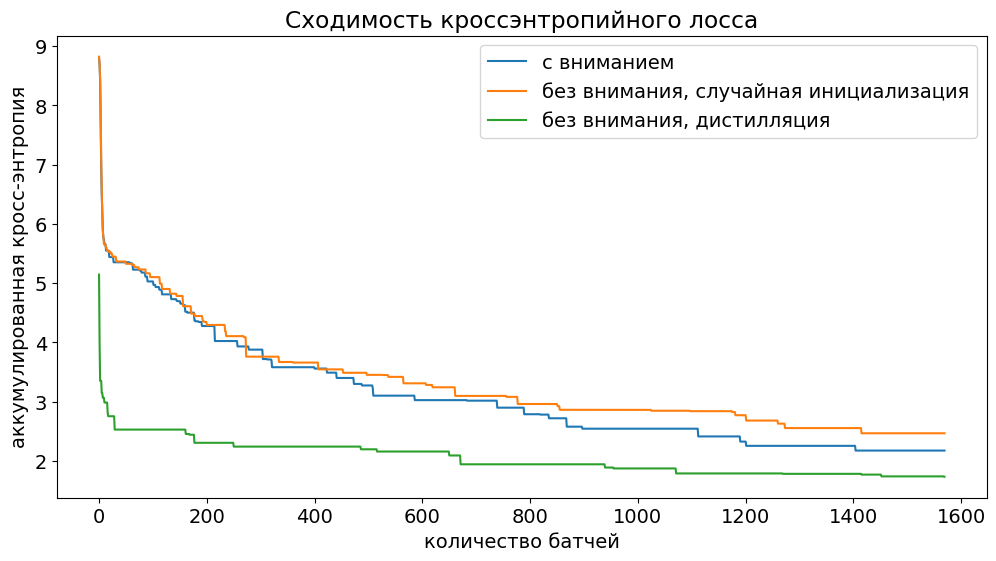

In [61]:
plt.figure(figsize=(12,6))

# plt.plot(train_history_rnn , label ='rnn (in my_network)')
plt.plot(np.minimum.accumulate(train_history_att) , label ='с вниманием')
plt.plot(np.minimum.accumulate(train_history_without_1) , label = 'без внимания, случайная инициализация')
plt.plot(np.minimum.accumulate(train_history_without_2) , label ='без внимания, дистилляция')
# plt.plot(train_history_without_3 , label ='without attention, distilation: Normal(teacher.params , I ) ')
plt.ylabel('аккумулированная кросс-энтропия')
plt.xlabel('количество батчей')
plt.title('Сходимость кроссэнтропийного лосса')
plt.legend()
plt.show()

## Bayesian distilation

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM =512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, without_attention = True)

modelWithoutAtt_3 = Seq2SeqAtt(enc, dec, device , without_attention = True).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def distil_weights_bayesian(m , teacher_model) :
    dict_names = {}
    for name, param in teacher_model.named_parameters():
        dict_names[name] = param
    for name, param in m.named_parameters():
        if name in dict_names.keys() :
            param.data.copy_(dict_names[name].data)

In [ ]:
train_history_without_3 , valid_history_without_3 ,_,_= trainer(model= modelWithoutAtt_3 ,init_weights=lambda m: distil_weights_bayesian(m , modelAtt) )

## Test Attention RNN

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = modelAtt(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:08,  6.64it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

26.595361211948347

## Модель обучается значительно медленнее из-за attention блока. Так же она медленнее инференсится примерно в 2 раза. Однако немного лучше сходится по train_loss. Имеется такое же переобучение, как и без attention. Сильное преимущество модели с вниманием: дает значительно больший скор BLEU, но число параметров примерно такое же.

# Модель с attention weights == E , то есть сумма скрытых слоев энкодера. С произвольной инициализацией весов

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM =512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, without_attention=True)

modelWithoutAtt = Seq2SeqAtt(enc, dec, device, without_attention=True).to(device)

In [ ]:
modelWithoutAtt.apply(init_weights)
count_parameters(modelWithoutAtt)

16801799

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(modelWithoutAtt.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

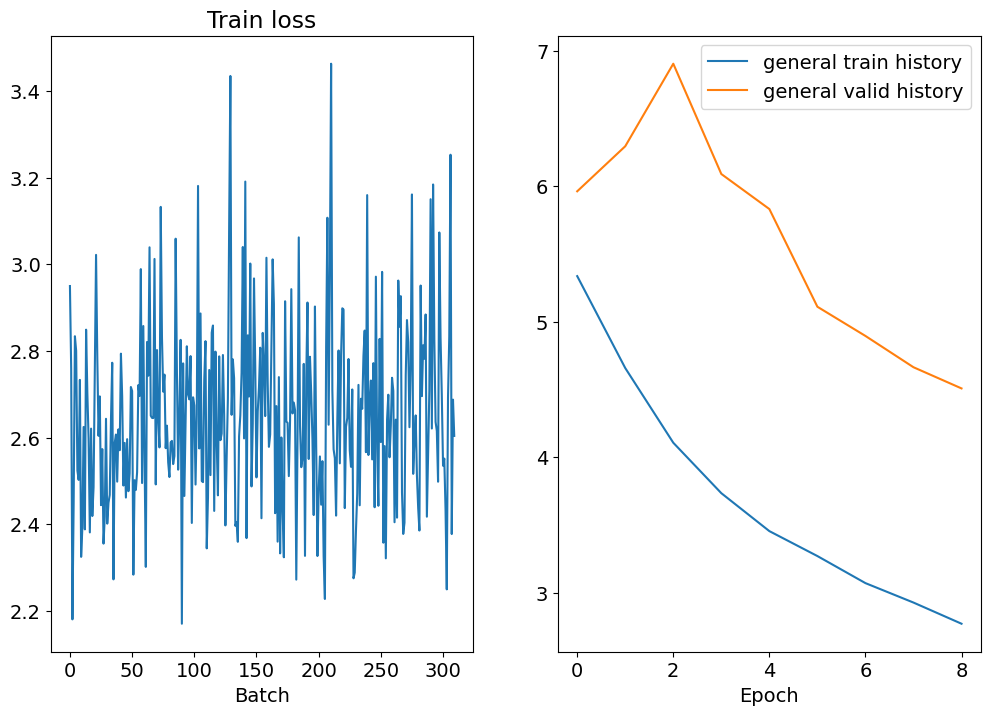

Epoch: 10 | Time: 2m 1s
	Train Loss: 2.652 | Train PPL:  14.182
	 Val. Loss: 4.539 |  Val. PPL:  93.624


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(modelWithoutAtt, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(modelWithoutAtt, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = modelWithoutAtt(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:07,  8.36it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

14.095775035904035

# Теперь проинициализируем веса модели, с помощью байесовской дистилляции модели с attention

# Улучшим RNN:  попробуем bidirectional rnn с attention (2 implementation over baseline)

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM =512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = EncoderAtt(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, bidirectional=True)
dec = DecoderAtt(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelBiAtt = Seq2SeqAtt(enc, dec, device).to(device)

In [ ]:
modelBiAtt.apply(init_weights)
count_parameters(modelBiAtt)

19430433

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(modelBiAtt.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

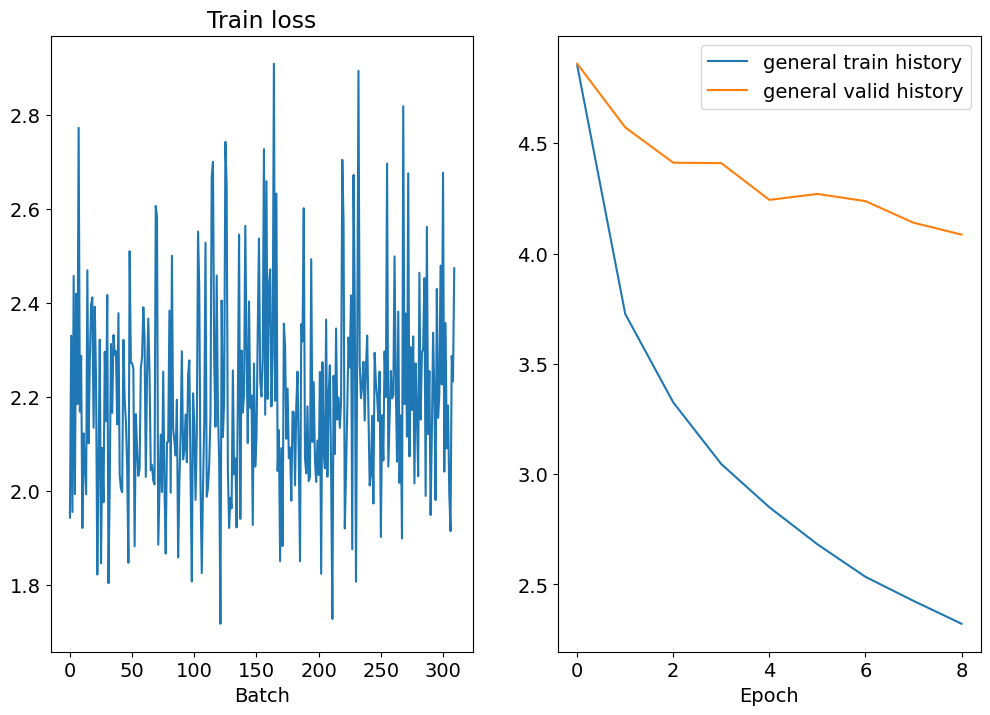

Epoch: 10 | Time: 2m 58s
	Train Loss: 2.197 | Train PPL:   9.002
	 Val. Loss: 4.196 |  Val. PPL:  66.417


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(modelBiAtt, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(modelBiAtt, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = modelBiAtt(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:08,  7.27it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.02440161991624

## При тех же гиперпараметрах , что у предыдущей модели, но с дополнительным обратным проходом lstm, модель выдает большее значение метрики bleu на 2 пункта. При этом время работы модели практически такое же , как у предыдущей.

# Обучим трансформер ( 3 implementation over baseline)

In [ ]:
import numpy as np

In [ ]:
import torch.nn as nn
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)
import torch
from torch import Tensor

import math

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int, NHEAD: int  ,
                 dim_feedforward:int = 512, dropout:float = 0.1 ):
        super(Seq2SeqTransformer, self).__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        # print('forward encode input shape: (src emb and src mask and src padding mask )' , src_emb.shape, src_mask.shape, src_padding_mask.shape)

        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        # print('forward encode output shape:' , memory.shape )


        # print('forward decode input shape: (tgt emb and tgt mask and tgt padding mask )' , tgt_emb.shape, memory.shape, tgt_mask.shape, None,
                                        # tgt_padding_mask.shape, memory_key_padding_mask.shape)


        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        # print('forward decode output shape:' , outs.shape )


        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        # print('encode input shape: (pos encoded src and src mask)' , self.positional_encoding(
        #                     self.src_tok_emb(src)).shape, src_mask.shape)
        # print('encode output shape:' , self.transformer_encoder(self.positional_encoding(
        #                     self.src_tok_emb(src)), src_mask).shape )

        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        # print('decode input shape: (pos encoded tgt and memory and tgt mask)' , self.positional_encoding(
        #                   self.tgt_tok_emb(tgt)).shape ,memory.shape,
        #                   tgt_mask.shape )
        # print('decode output shape:' , self.transformer_decoder(self.positional_encoding(
        #                   self.tgt_tok_emb(tgt)), memory,
        #                   tgt_mask).shape )
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
SRC_VOCAB_SIZE = len(SRC.vocab)
TGT_VOCAB_SIZE = len(TRG.vocab)
EMB_SIZE = 512
NHEAD = 16
FFN_HID_DIM = 1024
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4


transformer = Seq2SeqTransformer(num_encoder_layers=NUM_ENCODER_LAYERS,
                                num_decoder_layers= NUM_DECODER_LAYERS,
                                emb_size= EMB_SIZE, src_vocab_size= SRC_VOCAB_SIZE,
                                 tgt_vocab_size= TGT_VOCAB_SIZE,
                                 dim_feedforward= FFN_HID_DIM , NHEAD=NHEAD)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

In [ ]:
print(f'The model has {count_parameters(transformer):,} trainable parameters')

The model has 32,610,833 trainable parameters


In [ ]:
def train_transformer(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        tgt = batch.trg
        # print(src.shape , tgt.shape)
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]
        # print(tgt_input.shape)
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)
        # print(logits.shape)

        optimizer.zero_grad()

        tgt_out = tgt[1:,:]
        # print(tgt_out.shape)

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)


        optimizer.step()
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)





    logits = model(src, tgt_input, src_mask, tgt_mask,
                          src_padding_mask, tgt_padding_mask, src_padding_mask)

    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()

def evaluate_transformer(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            tgt = batch.trg
            src = src.to(device)
            tgt = tgt.to(device)
            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = model(src, tgt_input, src_mask, tgt_mask,
                          src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:,:]
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

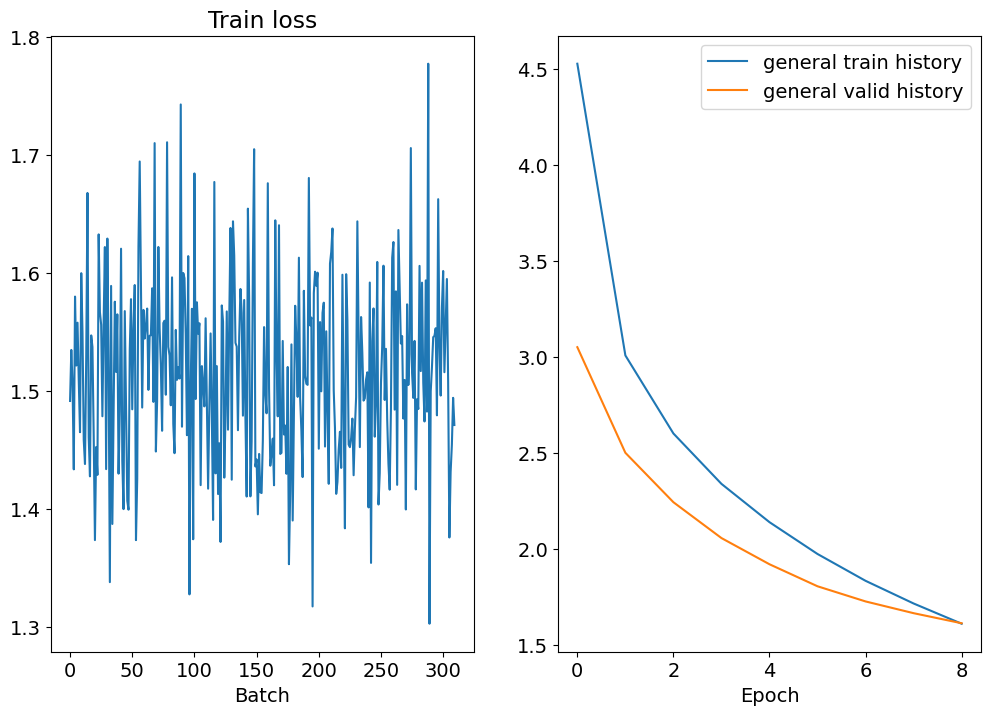

Epoch: 10 | Time: 2m 3s
	Train Loss: 1.516 | Train PPL:   4.553
	 Val. Loss: 1.562 |  Val. PPL:   4.766


In [ ]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train_transformer(transformer, train_iterator, optimizer, loss_fn, CLIP, train_history, valid_history)
    valid_loss = evaluate_transformer(transformer, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
BOS_IDX = SRC.vocab.stoi['<sos>']

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol, num_samples=1):
    src = src.to(device)
    src = torch.cat([src]*num_samples, dim=1)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)

    ys = torch.ones(1, num_samples).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.detach()

        ys = torch.cat([ys,
                        next_word.view(1, -1)], dim=0)
    return ys.transpose(0,1)

In [ ]:

def translate(
    model,
    srcs,
    src_vocab,
    tgt_vocab,
    # src_tokenizer,
    decoder=greedy_decode,
    max_len_add=10,
):
    model.eval()
    # itos = tgt_vocab.get_itos()
    global_answers = []

    for src in srcs:
        num_tokens = len(src)
        src = src.reshape(num_tokens, 1)

        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = decoder(
            model,
            src,
            src_mask,
            max_len=num_tokens + max_len_add,
            start_symbol= BOS_IDX
        )
        # print(tgt_tokens.shape)
        answers = []
        for tgt_token in tgt_tokens:
            reference = []
            for tok in tgt_token:
                tok = int(tok.detach().cpu())
                if tok == TRG.vocab.stoi["<eos>"]:
                    break
                if tok not in {
                    TRG.vocab.stoi["<eos>"],
                    TRG.vocab.stoi["<sos>"],
                    TRG.vocab.stoi["<pad>"],
                }:
                    reference.append(tok)
            global_answers.append(reference)
    return global_answers

In [ ]:
TRG.vocab.stoi["<sos>"]

2

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src.permute(1,0)
        trg = batch.trg
        src = src.to(device)


        tgt_output = translate(
            transformer,
            src,
            SRC.vocab,
            TRG.vocab,
            decoder=greedy_decode
        )
        original_text.append([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.append([get_text(x, TRG.vocab) for x in tgt_output])
        # break
original_text = flatten(original_text)
generated_text = flatten(generated_text)

59it [15:38, 15.91s/it]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

31.039753031616453

Выбили score > 27

## Выводы: Трансформер
* обучение достаточно быстрое
* переобучение практически не наступает
* Высокие значения BLEU
* Но очень долгий инференс

## Inference (дальше играюсь с переводом с помощью трансформера)

In [ ]:
def inference(idx , batch_idx, iterator) :
  for i,batch in enumerate(iterator) :
      if i == batch_idx :
          # print(batch.src.shape , batch.trg.shape)
          src = batch.src[:,idx:idx+1].permute(1,0)
          trg = batch.trg[:,idx:idx+1].permute(1,0)
          break
  src = src.to(device)
  tgt_output = translate(
      transformer,
      src,
      SRC.vocab,
      TRG.vocab,
      decoder=greedy_decode
  )
  # print(src)
  print('src       : ' , ' '.join([SRC.vocab.itos[token] if int(token) not in {1,2,3} else '' for token in src[0]]).strip())
  print('trg       : ', ' '.join([TRG.vocab.itos[token] if int(token) not in {1,2,3} else '' for token in trg[0]]).strip())
  print('translate : ', ' '.join(get_text(tgt_output[0], TRG.vocab)).strip())


In [ ]:
idx = np.random.randint(low=0,high=127)
batch_idx = np.random.randint(low=0,high=58)
inference(idx,batch_idx,test_iterator)

src       :  гостям предоставляется бесплатный трансфер от / до аэропорта .
trg       :  free transfer to the airport is provided .
translate :  the property offers free airport shuttle service .


In [ ]:
def translator( sentence ):
    src = tokenize(sentence)
    src = [SRC.vocab.stoi['<sos>']] + [SRC.vocab.stoi[word] for word in src ] + [SRC.vocab.stoi['<eos>']]
    src = torch.IntTensor([src])
    # print(src[0])
    src = src.to(device)

    tgt_output = translate(
        transformer,
        src,
        SRC.vocab,
        TRG.vocab,
        decoder=greedy_decode
    )
    # print(tgt_output[0])
    return ' '.join(get_text(tgt_output[0], TRG.vocab)).strip()



In [ ]:
sentence = 'Дом находится у моря'
print(translator(sentence))

the property is located in the sea .


In [ ]:
sentence = 'Столовая находится на пятом этаже'
print(translator(sentence))

the dining room is located on the ground floor .


In [ ]:
import numpy as np

In [ ]:
np.random.choice(np.arange(4,len(SRC.vocab),1),size=5)

array([3671, 6848, 7078, 4541,  132])

In [ ]:
sentence = ''
for j in range(10):
  sentence =' '.join([SRC.vocab.itos[i] for i in np.random.choice(np.arange(4,len(SRC.vocab),1),size = 5 )])

  print(f'{sentence:>80} -----------> {translator(sentence)}\n')

                                       мармариса деревянным пирса челси belhotel -----------> the white pier is blue metres from the property .

                                       hill киева такие destination обставленных -----------> hill bay is located at the distance of the bay .

                                           oceanview соленой изола туры majestic -----------> the white islands of the famous americas islands are offered .

                                   башен стандартным полноценная бульвара балета -----------> the most famous suites have a full full of them .

                          отправляются формате мексиканской сенанг фридрихсхафен -----------> the non - smoking rooms are offered .

                                                 попасть xviii бухты 170 многими -----------> the property offers its own parking .

                       масла коктейлями ассортиментом впечатляющим средневековый -----------> the large children ’ s playground is available f